In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


In [6]:
def imshow(img, title=None):
    if title is not None:
        plt.title(title)
    plt.axis("off")
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap="gray")
    plt.show()
    

In [7]:
RED_BGR = (0,0,255)
YELLOW_BGR = (0,255,255)
GREEN_BGR = (0,255,0)
BLUE_BGR = (255,0,0)

In [9]:
videopath = "./videos/easy/gameplay2.mp4"


1920 1080


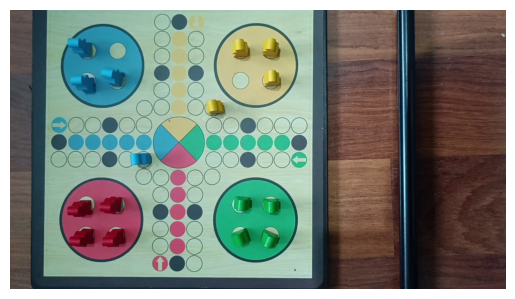

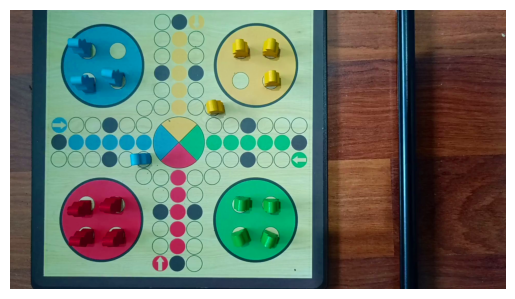

In [10]:
cap = cv2.VideoCapture(videopath)
if not cap.isOpened():
    raise Exception("Could not open")


frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

print(frame_width, frame_height)
# 
fps = cap.get(cv2.CAP_PROP_FPS)
fps

_, frame = cap.read()
imshow(frame)

def enhance(frame):
    hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)

    hsv[...,1] = np.minimum(hsv[...,1]*1.4, 255)
    
    # hsv[...,2] = hsv[...,2]*0.8

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
frame = enhance(frame)
imshow(frame)

In [12]:
# cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# _, frame = cap.read()
# # frame = enhance(frame)
# c = (60,500)
# x = frame[c]
# # o = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
# cv2.circle(frame, c[::-1], 8, (255,0,0), 3)
# imshow(frame)
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# frame[c]

In [11]:
from enum import Enum

class Color(Enum):
    YELLOW = 1
    RED = 2
    GREEN = 3
    BLUE = 4


In [12]:
def get_hsv_scale(lower_hsv, upper_hsv):
    width = upper_hsv[0] - lower_hsv[0]
    height = 100
    hsv_image = np.zeros((height, width, 3), dtype=np.uint8)

    for i in range(width):
        for j in range(height):
            hsv_value = [
                (lower_hsv[0] + i) % 180,  
                ((height - j) * upper_hsv[1] + lower_hsv[1] * j) // height, 
                upper_hsv[2]
            ]
            hsv_image[j, i] = hsv_value

    bgr_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    return bgr_image


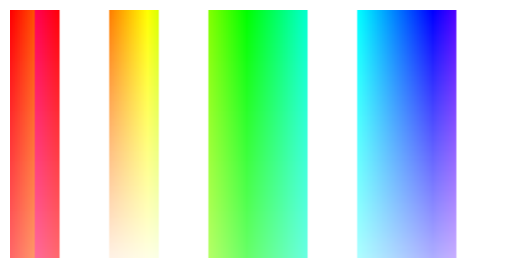

In [30]:
COLOR_RANGES = {
        Color.RED: [
            (np.array([0, 150, 70]), np.array([10, 255, 255])), 
            (np.array([170, 150, 70]), np.array([180, 255, 255]))
        ],
        Color.YELLOW: [
            (np.array([15, 25, 50]), np.array([35, 255, 255]))
        ],
        Color.GREEN: [
            (np.array([45, 150, 50]), np.array([85, 255, 255]))
        ],
        Color.BLUE: [
           (np.array([90, 80, 120]), np.array([130, 255, 255])) 
        ],
    }


scales = []
for ranges in COLOR_RANGES.values():
    for r in ranges:
        scales.append(get_hsv_scale(*r))
    scales.append(255*np.ones((100,20,3), dtype=np.uint8))
imshow(np.concatenate(scales,  1),)


In [14]:

def detect_dominant_color(image_fragment) -> Color:
    hsv = cv2.cvtColor(image_fragment, cv2.COLOR_BGR2HSV)
    
    
    color_counts = {color: 0 for color in COLOR_RANGES.keys()}
    for color, ranges in COLOR_RANGES.items():
        for lower, upper in ranges:
            mask = cv2.inRange(hsv, lower, upper)
            color_counts[color] += cv2.countNonZero(mask)
    dominant_color = max(color_counts, key=color_counts.get)
    
    return dominant_color


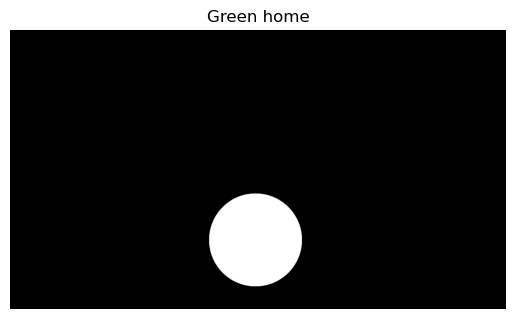

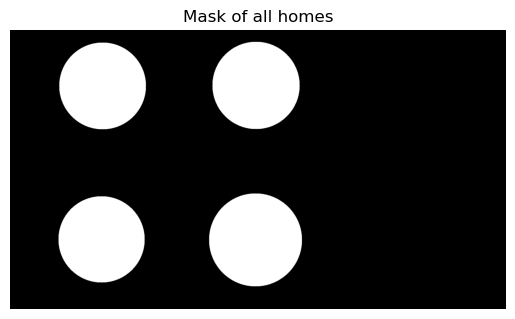

In [15]:
def get_home_masks(frame_gray):
    assert len(frame.shape) == 3, "frame must be BGR"   
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.medianBlur(frame_gray, 5)
    circles = cv2.HoughCircles(
        frame_gray,
        method = cv2.HOUGH_GRADIENT,
        dp = 1,
        minDist = int(min(frame_height, frame_width) * 0.4),
        param1 = 50,
        param2 = 30,
        minRadius=int(min(frame_height, frame_width) * 0.125),
        maxRadius=int(min(frame_height, frame_width) * 0.25),
    )

    homes = {
                 Color.RED: dict(center = None, radius = None, mask=None),      
                 Color.BLUE: dict(center = None, radius = None, mask=None),
                 Color.GREEN:  dict(center = None, radius = None, mask=None),
                 Color.YELLOW: dict(center = None, radius = None, mask=None),
        }
                 
        
    circles = np.uint16(np.around(circles))
    for ((x,y,r), color) in zip(circles[0,:], homes):
        mask =   np.zeros(frame_gray.shape + (3,), dtype=np.uint8)
        cv2.circle(mask ,(x,y),int(1.1*r),(255,255,255),-1)
        color = detect_dominant_color(frame & mask)
        homes[color]["center"] = (x,y)
        homes[color]["radius"] = r
        homes[color]["mask"] = mask

    return homes

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
homes = get_home_masks(frame)

imshow(homes[Color.GREEN]["mask"], title="Green home")
all_homes_mask = homes[Color.GREEN]["mask"] | homes [Color.RED]["mask"] | homes[Color.YELLOW]["mask"] | homes[Color.BLUE]["mask"]
imshow(all_homes_mask, title="Mask of all homes")

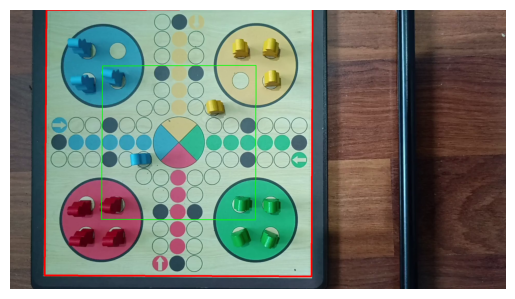

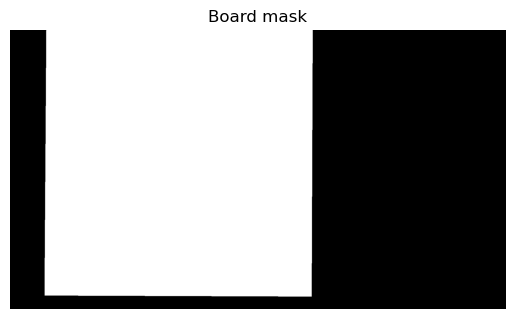

In [19]:
def get_board_mask_from_homes(frame, homes, verbose = False):
    
    corners = sorted([home["center"] for home in homes.values()], key = lambda x: x[1])
    top_points = corners[:2]
    bottom_points = corners[2:]
    
    top_left, top_right = sorted(top_points, key=lambda x: x[0])
    bottom_left, bottom_right = sorted(bottom_points, key=lambda x: x[0])

    contour = np.array([top_left, top_right, bottom_right, bottom_left],dtype=np.int32)
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        raise ValueError("Something wrong with home centers")

    home_dist_to_board_len_ratio = 26.0 / 15.0
    
    scaled_contour = []
    for point in contour:
        x, y = point
        # Scale the point relative to the centroid
        new_x = cx + home_dist_to_board_len_ratio * (x - cx)
        new_y = cy + home_dist_to_board_len_ratio * (y - cy)
        scaled_contour.append([[int(new_x), int(new_y)]])
        
    scaled_contour = np.array(scaled_contour, dtype=np.int32)
    # print(contour.shape)
    if verbose:
        output_image = frame.copy()
        cv2.drawContours(output_image, [contour], -1, (0,255,0),2)
        cv2.drawContours(output_image, [scaled_contour], -1, (0,0,255),5)
        imshow(output_image)

    board_mask = np.zeros_like(frame)
    cv2.drawContours(board_mask, [scaled_contour], -1, (255,255,255),-1)
    return board_mask

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
board_mask = get_board_mask_from_homes(frame, homes, verbose=True)
# if board_mask == None:
#     board_mask = np.ones_like(frame, dtype=np.uint8) * 255
# homes
imshow(board_mask, "Board mask")


dict_keys(['center', <Color.BLUE: 4>, <Color.YELLOW: 1>, <Color.RED: 2>, <Color.GREEN: 3>])


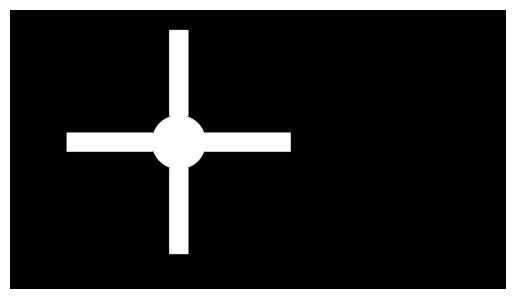

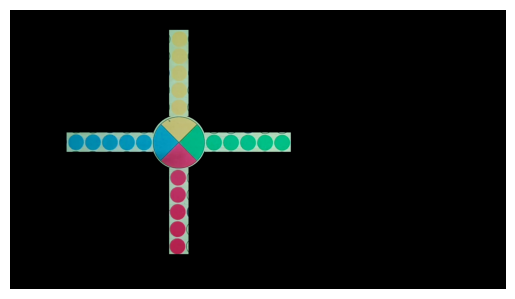

In [20]:
def get_target_bases(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(
            frame_gray,
            method = cv2.HOUGH_GRADIENT,
            dp = 2,
            minDist = int(min(frame_height, frame_width)),
            param1 = 100,
            param2=100,
            minRadius=int(min(frame_height, frame_width) * 0.055),
            maxRadius=int(min(frame_height, frame_width) * 0.1),
        )
    circles = np.uint16(np.around(circles))
    assert len(circles) == 1
    (x,y,r) = circles[0][0]
    targets = dict()
    

    center_circle_mask = np.zeros_like(frame)  
    cv2.circle(center_circle_mask ,(x,y),int(r*1.05),(255,255,255),-1)
    targets["center"] = center_circle_mask
    
    target_base_thickness = int(min(frame_height, frame_width) * 0.07)
    target_base_length = int(min(frame_height, frame_width) * 0.31)
    
    left_target_x = x-r-target_base_length
    left_target_y = y-target_base_thickness//2
    
    up_target_x = x - target_base_thickness//2
    up_target_y = y - r - target_base_length
    
    down_target_x = x - target_base_thickness//2
    down_target_y = y + r
    
    right_target_x = x + r
    right_target_y = y - target_base_thickness//2
    
    
    empty_mask = np.zeros_like(frame)  
    left_target_mask = cv2.rectangle(empty_mask, (left_target_x, left_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & left_target_mask)
    targets[color] = left_target_mask
    
    empty_mask = np.zeros_like(frame)
    up_target_mask = cv2.rectangle(empty_mask, (up_target_x, up_target_y, target_base_thickness, target_base_length ), (255,255,255), -1)
    color = detect_dominant_color(frame & up_target_mask)
    targets[color] = up_target_mask
    
    empty_mask = np.zeros_like(frame)
    down_target_mask = cv2.rectangle(empty_mask, (down_target_x, down_target_y, target_base_thickness, target_base_length), (255,255,255), -1)
    color = detect_dominant_color(frame & down_target_mask)
    targets[color] = down_target_mask
    
    empty_mask = np.zeros_like(frame)   
    right_target_mask = cv2.rectangle(empty_mask, (right_target_x, right_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & right_target_mask)
    targets[color] = right_target_mask

    
    return targets

cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret, frame = cap.read()
frame = enhance(frame)
targets = get_target_bases(frame & board_mask)
print(targets.keys())
all_target_bases_mask = targets["center"] | targets[Color.GREEN] | targets[Color.RED]| targets[Color.YELLOW]| targets[Color.BLUE]
imshow(all_target_bases_mask)
imshow(frame & all_target_bases_mask)


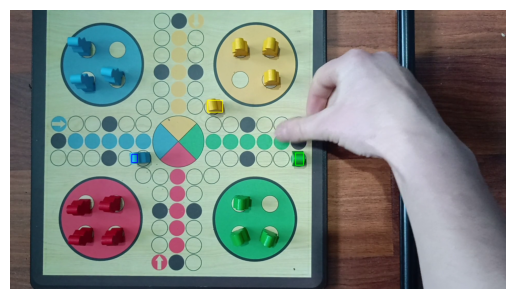

In [31]:
def get_pawn_boxes(sidewalk, color: Color):
    sidewalk_hsv = cv2.cvtColor(sidewalk, cv2.COLOR_BGR2HSV)
    

    
    ranges = COLOR_RANGES[color]
    mask = np.zeros(sidewalk.shape[:2], dtype=np.uint8)
    for lower, upper in ranges:
        mask |= cv2.inRange(sidewalk_hsv, lower, upper)
    # print(sidewalk_hsv[c], mask[c])
    # imshow(mask)

    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5),), iterations=8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7),), iterations=3)
    # imshow(mask)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pawn_boxes = []
    min_pawn_area = (min(frame_width, frame_height) * 0.017)**2
    max_pawn_area = (min(frame_width, frame_height) * 0.10)**2
    # imshow(mask)
    
    for contour in contours:
        mini_mask = np.zeros_like(mask)
        area = cv2.contourArea(contour)
        if min_pawn_area < area < max_pawn_area:
            cv2.drawContours(mini_mask, [contour], -1, (255), -1)
            non_zero_pixels = sidewalk_hsv[mini_mask != 0]
            if len(non_zero_pixels) > 0:
                avg_color = np.mean(non_zero_pixels, axis=0).astype(np.uint)
            else:
                avg_color = np.zeros((3,))
            # pawn_boxes.append((
            #     cv2.boundingRect(contour),
            #     avg_color
            # ))
            pawn_boxes.append(cv2.boundingRect(contour))
    
                
    return pawn_boxes   


cap.set(cv2.CAP_PROP_POS_FRAMES,2)
ret, frame = cap.read()
# frame = enhance(frame)

board = frame & board_mask
sidewalk = board & ~all_homes_mask & ~all_target_bases_mask
# imshow(board & sidewalk)
pawn_boxes = get_pawn_boxes(sidewalk, Color.BLUE)
for (x,y,w,h) in pawn_boxes:
    cv2.rectangle(frame, (x, y), (x+w, y+h), BLUE_BGR, 2)

pawn_boxes = get_pawn_boxes(sidewalk, Color.YELLOW)
for (x,y,w,h) in pawn_boxes:
    cv2.rectangle(frame, (x, y), (x+w, y+h), YELLOW_BGR, 2)

pawn_boxes = get_pawn_boxes(sidewalk, Color.RED)
for (x,y,w,h) in pawn_boxes:
    cv2.rectangle(frame, (x, y), (x+w, y+h), RED_BGR, 2)

pawn_boxes = get_pawn_boxes(sidewalk, Color.GREEN)
# # for ((x,y,w,h), avg_color) in pawn_boxes:
#     # cv2.putText(frame, str(avg_color), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,00,255), 2)
for (x,y,w,h) in pawn_boxes:
    cv2.rectangle(frame, (x, y), (x+w, y+h), GREEN_BGR, 2)
imshow(frame)

In [46]:
def render_video(in_path, out_path, seconds=None):
    
    cap = cv2.VideoCapture(in_path)
    if not cap.isOpened():
        raise Exception(f"Could not open {in_path}")
        
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)

    video_out = cv2.VideoWriter(
        out_path,
        cv2.VideoWriter_fourcc(*"DIVX"),
        fps,
        (frame_width, frame_height),
    )
    processed_frames = 0
    frames_to_generate = np.inf if seconds is None else seconds * fps
    
    cap.set(cv2.CAP_PROP_POS_FRAMES,0)
    while cap.isOpened():
        ret, frame = cap.read()
        if frame is None:
            print(ret)
            break

        board = board_mask & frame
        sidewalk = board & ~all_homes_mask & ~all_target_bases_mask
        
        pawn_boxes = get_pawn_boxes(sidewalk, Color.BLUE)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), BLUE_BGR, 2)
        
        pawn_boxes = get_pawn_boxes(sidewalk, Color.YELLOW)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), YELLOW_BGR, 2)
        
        pawn_boxes = get_pawn_boxes(sidewalk, Color.RED)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), RED_BGR, 2)
        
        pawn_boxes = get_pawn_boxes(sidewalk, Color.GREEN)
        for (x,y,w,h) in pawn_boxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), GREEN_BGR, 2)
            
        video_out.write(frame)
        processed_frames += 1
        if processed_frames >= frames_to_generate:
            break
    cap.release()
    video_out.release()

# Result 

In [47]:
%%time
render_video("videos/easy/gameplay1.mp4", "outs/easy/gameplay1.avi")
# render_video("videos/easy/gameplay2.mp4", "outs/easy/gameplay2.avi", 4)
# render_video("videos/easy/gameplay3.mp4", "outs/easy/gameplay3.avi",)

False
CPU times: user 8min 3s, sys: 2min 57s, total: 11min 1s
Wall time: 6min 45s


In [48]:
!mpv outs/easy/gameplay1.avi > /dev/null